# Multimodal Algorithm for Misinformation Detection

Implementing a proof of concept (PoC) for a multimodal algorithm for misinformation detection requires integrating multiple data sources (text, images, videos, etc.) and leveraging AI/ML techniques to analyze and classify misinformation. 

Text Data: https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English

Image Data: 

Video Data: 

**Install dependencies**

# 1. Data Collection & Preprocessing 

## Text Analysis: Using transformer model (BERT) for fake news detection.

### Explore FakeNewsNet Dataset

**The FakeNewsNet dataset includes fake and real news articles along with metadata such as user engagement and network interactions.**

In [16]:
from datasets import load_dataset
import pandas as pd

# Load FakeNewsNet dataset from Hugging Face
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

# Convert dataset to Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Display sample
print(df.head())

print("\nFakeNewsNet dataset explored successfully!")

   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22, 2017       1  
1       Jun 19, 2017      0  
2  November 2, 2017       1  
3       Sep 17, 2016      0  
4 

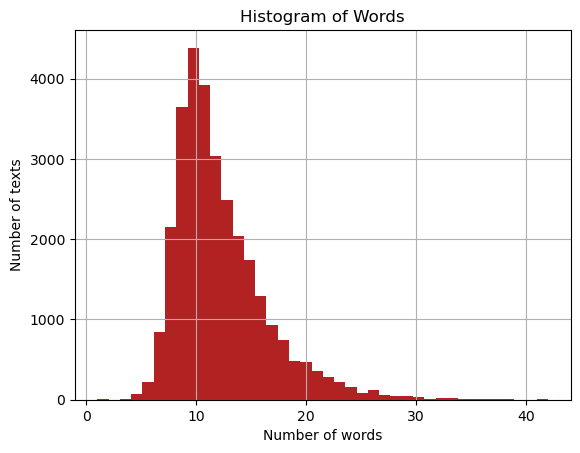

In [17]:
# Plot histogram of the number of words in the train data 'title'
import matplotlib.pyplot as plt
seq_len = [len(i.split()) for i in df['title']]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of words')
plt.ylabel('Number of texts')
plt.title('Histogram of Words')
plt.show()

label
0    15478
1    14522
dtype: int64


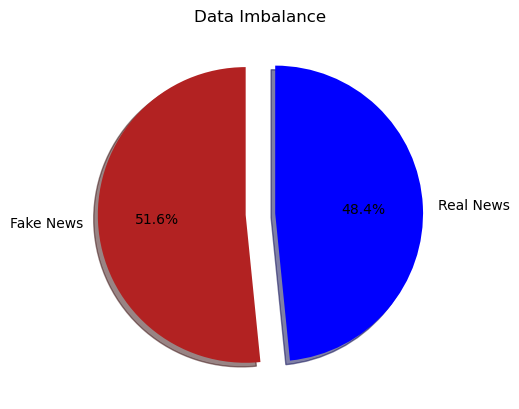

In [18]:
# Check data imbalance
label_size = df.groupby('label').size()
print(label_size)

plt.pie(label_size, explode=[0.1,0.1], colors=['firebrick','blue'], startangle=90,labels=['Fake News', 'Real News'], shadow=True, autopct='%1.1f%%')
plt.title('Data Imbalance')
plt.show()

## Text Data Preprocessing (BERT Tokenization)

In [19]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_text(texts):
    """
    Tokenize a batch of texts with BERT.
    
    Args:
    texts (list of str): List of text samples to tokenize.
    
    Returns:
    dict: Dictionary containing input_ids, attention_mask, and token_type_ids.
    """
    encoded_inputs = tokenizer(
        texts,
        padding="max_length",  # Pad to max_length for batch consistency
        truncation=True,       # Truncate texts longer than 20 tokens
        max_length=15,        # BERT max token limit
        return_tensors="pt"    # Return PyTorch tensors
    )
    
    return {
        "input_ids": encoded_inputs["input_ids"],
        "attention_mask": encoded_inputs["attention_mask"],
        "token_type_ids": encoded_inputs["token_type_ids"]
    }

# Example usage with a batch of texts
sample_text = ["Fake news detection using multimodal learning.",
               "Using Bert."]

# Tokenize and print results
tokenized_output = preprocess_text(sample_text)
print(tokenized_output)


{'input_ids': tensor([[  101,  8275,  2739, 10788,  2478,  4800,  5302,  9305,  4083,  1012,
           102,     0,     0,     0,     0],
        [  101,  2478, 14324,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


## Training

In [20]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load dataset from Hugging Face
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

# Select all the rows in training dataset
train_data = dataset["train"]
test_data = dataset["test"]
val_data = dataset["validation"]

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=20)

# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

# Convert labels to tensor format
def format_dataset(data):
    return data.with_format("torch", columns=["input_ids", "attention_mask", "label"])

train_data = format_dataset(train_data)
test_data = format_dataset(test_data)
val_data = format_dataset(val_data)

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8)
val_dataloader = DataLoader(val_data, batch_size=8)

# Load BERT model with classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define optimizer
# optimizer = AdamW(model.parameters(), lr=5e-5)
# Define the hyperparameters (optimizer, weights of the classes and the epochs)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Define learning rate scheduler
num_training_steps = len(train_dataloader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Define the loss functions
criterion = torch.nn.CrossEntropyLoss()

# Save model directory
best_model_path = "best_bert_fake_news_detector"
os.makedirs(best_model_path, exist_ok=True)

# Initialize best accuracy tracking
best_val_accuracy = 0.0

# Evaluation function
def evaluate_model(dataloader, split_name):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating on {split_name}"):
            batch = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["label"].to(device),  # Rename 'label' to 'labels'
            }
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    accuracy = correct / total
    print(f"📊 {split_name} Accuracy: {accuracy:.4f}")
    return accuracy


# Training loop with best model saving

num_epochs = 3
print("\n🚀 Training Started...")
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, leave=True)
    
    for batch in loop:
        batch = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "labels": batch["label"].to(device),  # Rename 'label' to 'labels'
        }
        
        outputs = model(**batch)  # No error now
        loss = criterion(outputs.logits, batch["labels"])

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    # Evaluate after each epoch
    val_accuracy = evaluate_model(val_dataloader, "Validation")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_val_accuracy
        }, os.path.join(best_model_path, "checkpoint.pth"))
        print(f"✅ Best model saved with Validation Accuracy: {val_accuracy:.4f}")

print("✅ Training Completed!")


# Load the best model for evaluation
print("\n🔄 Loading the best model...")
best_model = BertForSequenceClassification.from_pretrained(best_model_path)
best_tokenizer = BertTokenizer.from_pretrained(best_model_path)
best_model.to(device)
print("✅ Best model loaded successfully!")




Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Training Started...


Evaluating on Validation: 100%|██████████| 750/750 [00:08<00:00, 88.08it/s]


📊 Validation Accuracy: 0.9687
✅ Best model saved with Validation Accuracy: 0.9687


Evaluating on Validation: 100%|██████████| 750/750 [00:08<00:00, 87.89it/s]


📊 Validation Accuracy: 0.9755
✅ Best model saved with Validation Accuracy: 0.9755


Evaluating on Validation: 100%|██████████| 750/750 [00:08<00:00, 87.63it/s]


📊 Validation Accuracy: 0.9755
✅ Training Completed!

🔄 Loading the best model...
✅ Best model loaded successfully!


## Evaluation

In [7]:
# Evaluate on test set
evaluate_model(test_dataloader, "Test")

Evaluating on Test: 100%|██████████| 1034/1034 [00:11<00:00, 90.13it/s]

📊 Test Accuracy: 0.9764


0.9764122414418773

**After training, you can load the model and make predictions**

## Model Performance

In [8]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

def classification_report_test(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating on Test Set"):
            batch = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["label"].to(device),  # Ensure correct label key
            }
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())  # Convert to NumPy for sklearn
            all_labels.extend(batch["labels"].cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
    print("\n📊 Classification Report on Test Set:\n")
    print(report)

classification_report_test(model, test_dataloader)


Evaluating on Test Set: 100%|██████████| 1034/1034 [00:11<00:00, 90.44it/s]


📊 Classification Report on Test Set:

              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      4284
        Fake       0.98      0.98      0.98      3983

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267



Interpretation:

* Precision: How many of the predicted "Fake" news are actually fake?

* Recall: How many actual "Fake" news were correctly identified?

* F1-score: The harmonic mean of precision & recall.

* Support: Number of test samples in each class.


***

# Image Analysis: Using CNNs for detecting manipulated images.

### Prepare to Load the Image Manipulation Dataset

In [3]:
# Initialize image processor
image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
    use_fast=True
)

# Disable PIL's size limit
Image.MAX_IMAGE_PIXELS = None

def print_memory_usage():
    """Monitor memory usage"""
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def preprocess_image(image, max_size=1024):
    """Process a single image with size limiting"""
    try:
        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Get image dimensions
        width, height = image.size
        
        # Resize if the image is too large
        if width > max_size or height > max_size:
            aspect_ratio = width / height
            if width > height:
                new_width = max_size
                new_height = int(max_size / aspect_ratio)
            else:
                new_height = max_size
                new_width = int(max_size * aspect_ratio)
            image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Process the image
        processed = image_processor(image, return_tensors="pt")
        return processed.pixel_values[0]
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

class StreamingImageDataset(Dataset):
    def __init__(self, dataset_split, buffer_size=1000):
        """
        Initialize the dataset with a buffer to store samples
        Args:
            dataset_split: The dataset split (train or test)
            buffer_size: Number of samples to keep in memory
        """
        self.dataset = dataset_split
        self.buffer_size = buffer_size
        self.buffer = []
        self.current_index = 0
        
        # Fill initial buffer
        self._fill_buffer()
    
    def _fill_buffer(self):
        """Fill the buffer with processed images"""
        print("Filling data buffer...")
        self.buffer = []
        
        for i, item in enumerate(self.dataset.take(self.buffer_size)):
            processed_image = preprocess_image(item['image'])
            if processed_image is not None:
                self.buffer.append((processed_image, item['label']))
            
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1} images")
                print_memory_usage()
        
        print(f"Buffer filled with {len(self.buffer)} images")
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, idx):
        return self.buffer[idx]

def create_data_loaders(batch_size=32, buffer_size=1000):
    """Create data loaders with streaming datasets"""
    print("Loading dataset...")
    
    try:
        # Load dataset
        dataset = load_dataset("date3k2/raw_real_fake_images", streaming=True)
        
        # Create streaming datasets
        train_dataset = StreamingImageDataset(dataset['train'], buffer_size=buffer_size)
        test_dataset = StreamingImageDataset(dataset['test'], buffer_size=buffer_size)
        
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise

def train_model(model, train_loader, test_loader, num_epochs=3, save_dir='model_checkpoints'):
    """Train the model with checkpointing and monitoring"""
    os.makedirs(save_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (images, labels) in enumerate(progress_bar):
            print_memory_usage()  # Monitor memory usage
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{running_loss/(batch_idx+1):.4f}',
                'accuracy': f'{correct/total:.4f}'
            })
            
            # Clear some memory
            del outputs, loss
            gc.collect()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader, device)
        
        # Save checkpoint if best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_accuracy,
            }
            torch.save(checkpoint, os.path.join(save_dir, 'best_model.pth'))
            print(f"✅ New best model saved with accuracy: {test_accuracy:.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("-" * 50)

def evaluate_model(model, dataloader, device):
    """Evaluate the model"""
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Clear some memory
            del outputs
            gc.collect()
    
    accuracy = correct / total
    return accuracy
    
print("✅ Prepared to Load Data and Train Model!")

✅ Prepared to Load Data and Train Model!


### Train and Evaluate the Image Model

In [4]:
if __name__ == "__main__":
    # Configuration
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000  # Adjust based on your available memory
    NUM_EPOCHS = 3
    SAVE_DIR = 'model_results'
    
    try:
        # Create data loaders
        print("Initializing data loaders...")
        train_loader, test_loader = create_data_loaders(
            batch_size=BATCH_SIZE,
            buffer_size=BUFFER_SIZE
        )
        print("✅ DataLoaders Ready!")
        
        # Initialize model
        print("Loading Pretrained Vision Transformer (ViT) Model...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = AutoModelForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=2,
            ignore_mismatched_sizes=True
        )
        model.to(device)
        print("✅ Vision Transformer (ViT) Model Loaded!")
        
        # Train model
        train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            num_epochs=NUM_EPOCHS,
            save_dir=SAVE_DIR
        )
        
        # Final evaluation
        print("\nPerforming final evaluation...")
        final_accuracy = evaluate_model(model, test_loader, device)
        print(f"Final Test Accuracy: {final_accuracy:.4f}")
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

Initializing data loaders...
Loading dataset...
Filling data buffer...
Processed 100 images
Memory usage: 2255.98 MB
Processed 200 images
Memory usage: 2414.75 MB
Processed 300 images
Memory usage: 2342.66 MB
Processed 400 images
Memory usage: 2344.09 MB
Processed 500 images
Memory usage: 2410.66 MB
Processed 600 images
Memory usage: 2424.64 MB
Processed 700 images
Memory usage: 2859.21 MB
Processed 800 images
Memory usage: 2915.18 MB
Processed 900 images
Memory usage: 2916.18 MB
Processed 1000 images
Memory usage: 2866.06 MB
Buffer filled with 1000 images
Filling data buffer...
Processed 100 images
Memory usage: 3171.92 MB
Processed 200 images
Memory usage: 3161.13 MB
Processed 300 images
Memory usage: 3115.22 MB
Processed 400 images
Memory usage: 3105.61 MB
Processed 500 images
Memory usage: 3066.36 MB
Processed 600 images
Memory usage: 3440.13 MB
Processed 700 images
Memory usage: 3484.18 MB
Processed 800 images
Memory usage: 3462.93 MB
Processed 900 images
Memory usage: 3538.13 MB


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Vision Transformer (ViT) Model Loaded!


Epoch 1/3:   0%|          | 0/63 [00:00<?, ?it/s]

Memory usage: 3289.46 MB


Epoch 1/3:   2%|▏         | 1/63 [00:01<01:22,  1.33s/it, loss=0.7495, accuracy=0.4375]

Memory usage: 3602.40 MB


Epoch 1/3:   3%|▎         | 2/63 [00:02<00:59,  1.03it/s, loss=0.7264, accuracy=0.4688]

Memory usage: 3602.40 MB


Epoch 1/3:   5%|▍         | 3/63 [00:02<00:51,  1.16it/s, loss=0.7823, accuracy=0.3958]

Memory usage: 3602.40 MB


Epoch 1/3:   6%|▋         | 4/63 [00:03<00:47,  1.24it/s, loss=0.7663, accuracy=0.4375]

Memory usage: 3602.40 MB


Epoch 1/3:   8%|▊         | 5/63 [00:04<00:45,  1.28it/s, loss=0.7410, accuracy=0.4625]

Memory usage: 3602.40 MB


Epoch 1/3:  10%|▉         | 6/63 [00:04<00:43,  1.30it/s, loss=0.7256, accuracy=0.4583]

Memory usage: 3602.40 MB


Epoch 1/3:  11%|█         | 7/63 [00:05<00:42,  1.32it/s, loss=0.7314, accuracy=0.4732]

Memory usage: 3602.40 MB


Epoch 1/3:  13%|█▎        | 8/63 [00:06<00:41,  1.33it/s, loss=0.7310, accuracy=0.4844]

Memory usage: 3602.40 MB


Epoch 1/3:  14%|█▍        | 9/63 [00:07<00:40,  1.34it/s, loss=0.7221, accuracy=0.5069]

Memory usage: 3602.40 MB


Epoch 1/3:  16%|█▌        | 10/63 [00:07<00:39,  1.35it/s, loss=0.7249, accuracy=0.5000]

Memory usage: 3602.40 MB


Epoch 1/3:  17%|█▋        | 11/63 [00:08<00:38,  1.36it/s, loss=0.7258, accuracy=0.5000]

Memory usage: 3602.40 MB


Epoch 1/3:  19%|█▉        | 12/63 [00:09<00:37,  1.36it/s, loss=0.7262, accuracy=0.4948]

Memory usage: 3602.40 MB


Epoch 1/3:  21%|██        | 13/63 [00:10<00:36,  1.37it/s, loss=0.7231, accuracy=0.5000]

Memory usage: 3602.40 MB


Epoch 1/3:  22%|██▏       | 14/63 [00:10<00:35,  1.37it/s, loss=0.7205, accuracy=0.5045]

Memory usage: 3602.40 MB


Epoch 1/3:  24%|██▍       | 15/63 [00:11<00:35,  1.37it/s, loss=0.7078, accuracy=0.5250]

Memory usage: 3602.40 MB


Epoch 1/3:  25%|██▌       | 16/63 [00:12<00:34,  1.37it/s, loss=0.7064, accuracy=0.5273]

Memory usage: 3602.59 MB


Epoch 1/3:  27%|██▋       | 17/63 [00:13<00:33,  1.37it/s, loss=0.6994, accuracy=0.5368]

Memory usage: 3602.59 MB


Epoch 1/3:  29%|██▊       | 18/63 [00:13<00:32,  1.38it/s, loss=0.6881, accuracy=0.5521]

Memory usage: 3602.59 MB


Epoch 1/3:  30%|███       | 19/63 [00:14<00:31,  1.38it/s, loss=0.6897, accuracy=0.5493]

Memory usage: 3602.59 MB


Epoch 1/3:  32%|███▏      | 20/63 [00:15<00:31,  1.37it/s, loss=0.6888, accuracy=0.5469]

Memory usage: 3602.59 MB


Epoch 1/3:  33%|███▎      | 21/63 [00:15<00:30,  1.37it/s, loss=0.6834, accuracy=0.5536]

Memory usage: 3602.59 MB


Epoch 1/3:  35%|███▍      | 22/63 [00:16<00:29,  1.37it/s, loss=0.6805, accuracy=0.5597]

Memory usage: 3602.59 MB


Epoch 1/3:  37%|███▋      | 23/63 [00:17<00:29,  1.36it/s, loss=0.6809, accuracy=0.5652]

Memory usage: 3602.59 MB


Epoch 1/3:  38%|███▊      | 24/63 [00:18<00:28,  1.36it/s, loss=0.6765, accuracy=0.5755]

Memory usage: 3602.59 MB


Epoch 1/3:  40%|███▉      | 25/63 [00:18<00:27,  1.36it/s, loss=0.6683, accuracy=0.5850]

Memory usage: 3602.59 MB


Epoch 1/3:  41%|████▏     | 26/63 [00:19<00:27,  1.36it/s, loss=0.6675, accuracy=0.5889]

Memory usage: 3602.59 MB


Epoch 1/3:  43%|████▎     | 27/63 [00:20<00:26,  1.37it/s, loss=0.6640, accuracy=0.5949]

Memory usage: 3602.59 MB


Epoch 1/3:  44%|████▍     | 28/63 [00:21<00:25,  1.37it/s, loss=0.6594, accuracy=0.6027]

Memory usage: 3602.59 MB


Epoch 1/3:  46%|████▌     | 29/63 [00:21<00:24,  1.37it/s, loss=0.6537, accuracy=0.6142]

Memory usage: 3602.59 MB


Epoch 1/3:  48%|████▊     | 30/63 [00:22<00:24,  1.37it/s, loss=0.6511, accuracy=0.6208]

Memory usage: 3602.59 MB


Epoch 1/3:  49%|████▉     | 31/63 [00:23<00:23,  1.37it/s, loss=0.6452, accuracy=0.6331]

Memory usage: 3602.59 MB


Epoch 1/3:  51%|█████     | 32/63 [00:23<00:22,  1.37it/s, loss=0.6416, accuracy=0.6367]

Memory usage: 3602.59 MB


Epoch 1/3:  52%|█████▏    | 33/63 [00:24<00:21,  1.37it/s, loss=0.6401, accuracy=0.6383]

Memory usage: 3602.59 MB


Epoch 1/3:  54%|█████▍    | 34/63 [00:25<00:21,  1.37it/s, loss=0.6370, accuracy=0.6379]

Memory usage: 3602.59 MB


Epoch 1/3:  56%|█████▌    | 35/63 [00:26<00:20,  1.37it/s, loss=0.6336, accuracy=0.6411]

Memory usage: 3602.59 MB


Epoch 1/3:  57%|█████▋    | 36/63 [00:26<00:19,  1.37it/s, loss=0.6325, accuracy=0.6406]

Memory usage: 3602.59 MB


Epoch 1/3:  59%|█████▊    | 37/63 [00:27<00:19,  1.37it/s, loss=0.6315, accuracy=0.6402]

Memory usage: 3602.59 MB


Epoch 1/3:  60%|██████    | 38/63 [00:28<00:18,  1.37it/s, loss=0.6290, accuracy=0.6398]

Memory usage: 3602.59 MB


Epoch 1/3:  62%|██████▏   | 39/63 [00:29<00:17,  1.37it/s, loss=0.6287, accuracy=0.6410]

Memory usage: 3602.59 MB


Epoch 1/3:  63%|██████▎   | 40/63 [00:29<00:16,  1.36it/s, loss=0.6230, accuracy=0.6469]

Memory usage: 3602.62 MB


Epoch 1/3:  65%|██████▌   | 41/63 [00:30<00:16,  1.37it/s, loss=0.6203, accuracy=0.6509]

Memory usage: 3602.62 MB


Epoch 1/3:  67%|██████▋   | 42/63 [00:31<00:15,  1.36it/s, loss=0.6182, accuracy=0.6533]

Memory usage: 3602.62 MB


Epoch 1/3:  68%|██████▊   | 43/63 [00:32<00:14,  1.36it/s, loss=0.6179, accuracy=0.6541]

Memory usage: 3602.62 MB


Epoch 1/3:  70%|██████▉   | 44/63 [00:32<00:13,  1.36it/s, loss=0.6155, accuracy=0.6577]

Memory usage: 3602.62 MB


Epoch 1/3:  71%|███████▏  | 45/63 [00:33<00:13,  1.37it/s, loss=0.6154, accuracy=0.6569]

Memory usage: 3602.62 MB


Epoch 1/3:  73%|███████▎  | 46/63 [00:34<00:12,  1.37it/s, loss=0.6165, accuracy=0.6562]

Memory usage: 3602.62 MB


Epoch 1/3:  75%|███████▍  | 47/63 [00:34<00:11,  1.37it/s, loss=0.6171, accuracy=0.6569]

Memory usage: 3602.62 MB


Epoch 1/3:  76%|███████▌  | 48/63 [00:35<00:10,  1.37it/s, loss=0.6132, accuracy=0.6615]

Memory usage: 3602.62 MB


Epoch 1/3:  78%|███████▊  | 49/63 [00:36<00:10,  1.36it/s, loss=0.6107, accuracy=0.6658]

Memory usage: 3602.62 MB


Epoch 1/3:  79%|███████▉  | 50/63 [00:37<00:09,  1.36it/s, loss=0.6089, accuracy=0.6675]

Memory usage: 3602.62 MB


Epoch 1/3:  81%|████████  | 51/63 [00:37<00:08,  1.35it/s, loss=0.6063, accuracy=0.6716]

Memory usage: 3602.62 MB


Epoch 1/3:  83%|████████▎ | 52/63 [00:38<00:08,  1.36it/s, loss=0.6057, accuracy=0.6731]

Memory usage: 3602.62 MB


Epoch 1/3:  84%|████████▍ | 53/63 [00:39<00:07,  1.37it/s, loss=0.6028, accuracy=0.6757]

Memory usage: 3602.62 MB


Epoch 1/3:  86%|████████▌ | 54/63 [00:40<00:06,  1.36it/s, loss=0.6014, accuracy=0.6806]

Memory usage: 3602.62 MB


Epoch 1/3:  87%|████████▋ | 55/63 [00:40<00:05,  1.36it/s, loss=0.6000, accuracy=0.6818]

Memory usage: 3602.62 MB


Epoch 1/3:  89%|████████▉ | 56/63 [00:41<00:05,  1.36it/s, loss=0.5962, accuracy=0.6842]

Memory usage: 3602.62 MB


Epoch 1/3:  90%|█████████ | 57/63 [00:42<00:04,  1.36it/s, loss=0.5943, accuracy=0.6864]

Memory usage: 3602.63 MB


Epoch 1/3:  92%|█████████▏| 58/63 [00:43<00:03,  1.36it/s, loss=0.5936, accuracy=0.6853]

Memory usage: 3602.63 MB


Epoch 1/3:  94%|█████████▎| 59/63 [00:43<00:02,  1.36it/s, loss=0.5923, accuracy=0.6843]

Memory usage: 3610.63 MB


Epoch 1/3:  95%|█████████▌| 60/63 [00:44<00:02,  1.36it/s, loss=0.5902, accuracy=0.6854]

Memory usage: 3610.63 MB


Epoch 1/3:  97%|█████████▋| 61/63 [00:45<00:01,  1.36it/s, loss=0.5882, accuracy=0.6875]

Memory usage: 3610.63 MB


Epoch 1/3:  98%|█████████▊| 62/63 [00:45<00:00,  1.36it/s, loss=0.5861, accuracy=0.6895]

Memory usage: 3610.63 MB


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


✅ New best model saved with accuracy: 0.8220
Epoch 1/3
Training Loss: 0.5836, Training Accuracy: 0.6900
Test Accuracy: 0.8220
--------------------------------------------------


Epoch 2/3:   0%|          | 0/63 [00:00<?, ?it/s]

Memory usage: 3629.47 MB


Epoch 2/3:   2%|▏         | 1/63 [00:00<00:59,  1.05it/s, loss=0.2381, accuracy=1.0000]

Memory usage: 3629.72 MB


Epoch 2/3:   3%|▎         | 2/63 [00:01<00:50,  1.22it/s, loss=0.2268, accuracy=1.0000]

Memory usage: 3629.72 MB


Epoch 2/3:   5%|▍         | 3/63 [00:02<00:47,  1.27it/s, loss=0.2619, accuracy=0.9583]

Memory usage: 3629.72 MB


Epoch 2/3:   6%|▋         | 4/63 [00:03<00:44,  1.31it/s, loss=0.2596, accuracy=0.9688]

Memory usage: 3629.72 MB


Epoch 2/3:   8%|▊         | 5/63 [00:03<00:43,  1.33it/s, loss=0.2490, accuracy=0.9750]

Memory usage: 3629.72 MB


Epoch 2/3:  10%|▉         | 6/63 [00:04<00:42,  1.34it/s, loss=0.2448, accuracy=0.9688]

Memory usage: 3629.72 MB


Epoch 2/3:  11%|█         | 7/63 [00:05<00:41,  1.35it/s, loss=0.2448, accuracy=0.9643]

Memory usage: 3629.72 MB


Epoch 2/3:  13%|█▎        | 8/63 [00:06<00:40,  1.36it/s, loss=0.2505, accuracy=0.9688]

Memory usage: 3629.72 MB


Epoch 2/3:  14%|█▍        | 9/63 [00:06<00:39,  1.36it/s, loss=0.2528, accuracy=0.9722]

Memory usage: 3629.72 MB


Epoch 2/3:  16%|█▌        | 10/63 [00:07<00:39,  1.36it/s, loss=0.2544, accuracy=0.9750]

Memory usage: 3629.72 MB


Epoch 2/3:  17%|█▋        | 11/63 [00:08<00:38,  1.36it/s, loss=0.2629, accuracy=0.9659]

Memory usage: 3629.72 MB


Epoch 2/3:  19%|█▉        | 12/63 [00:09<00:37,  1.36it/s, loss=0.2642, accuracy=0.9635]

Memory usage: 3629.72 MB


Epoch 2/3:  21%|██        | 13/63 [00:09<00:36,  1.37it/s, loss=0.2661, accuracy=0.9615]

Memory usage: 3629.72 MB


Epoch 2/3:  22%|██▏       | 14/63 [00:10<00:35,  1.37it/s, loss=0.2697, accuracy=0.9598]

Memory usage: 3629.72 MB


Epoch 2/3:  24%|██▍       | 15/63 [00:11<00:35,  1.36it/s, loss=0.2699, accuracy=0.9583]

Memory usage: 3629.72 MB


Epoch 2/3:  25%|██▌       | 16/63 [00:11<00:34,  1.36it/s, loss=0.2668, accuracy=0.9609]

Memory usage: 3629.75 MB


Epoch 2/3:  27%|██▋       | 17/63 [00:12<00:33,  1.36it/s, loss=0.2719, accuracy=0.9522]

Memory usage: 3629.75 MB


Epoch 2/3:  29%|██▊       | 18/63 [00:13<00:32,  1.36it/s, loss=0.2720, accuracy=0.9514]

Memory usage: 3629.75 MB


Epoch 2/3:  30%|███       | 19/63 [00:14<00:32,  1.36it/s, loss=0.2689, accuracy=0.9539]

Memory usage: 3629.75 MB


Epoch 2/3:  32%|███▏      | 20/63 [00:14<00:31,  1.36it/s, loss=0.2675, accuracy=0.9563]

Memory usage: 3629.75 MB


Epoch 2/3:  33%|███▎      | 21/63 [00:15<00:30,  1.36it/s, loss=0.2634, accuracy=0.9583]

Memory usage: 3629.75 MB


Epoch 2/3:  35%|███▍      | 22/63 [00:16<00:30,  1.36it/s, loss=0.2615, accuracy=0.9602]

Memory usage: 3629.75 MB


Epoch 2/3:  37%|███▋      | 23/63 [00:17<00:29,  1.36it/s, loss=0.2608, accuracy=0.9592]

Memory usage: 3629.75 MB


Epoch 2/3:  38%|███▊      | 24/63 [00:17<00:28,  1.36it/s, loss=0.2565, accuracy=0.9609]

Memory usage: 3629.75 MB


Epoch 2/3:  40%|███▉      | 25/63 [00:18<00:27,  1.36it/s, loss=0.2538, accuracy=0.9625]

Memory usage: 3629.76 MB


Epoch 2/3:  41%|████▏     | 26/63 [00:19<00:27,  1.36it/s, loss=0.2510, accuracy=0.9639]

Memory usage: 3629.76 MB


Epoch 2/3:  43%|████▎     | 27/63 [00:20<00:26,  1.36it/s, loss=0.2541, accuracy=0.9606]

Memory usage: 3629.76 MB


Epoch 2/3:  44%|████▍     | 28/63 [00:20<00:25,  1.36it/s, loss=0.2551, accuracy=0.9576]

Memory usage: 3629.76 MB


Epoch 2/3:  46%|████▌     | 29/63 [00:21<00:25,  1.35it/s, loss=0.2554, accuracy=0.9547]

Memory usage: 3629.76 MB


Epoch 2/3:  48%|████▊     | 30/63 [00:22<00:24,  1.36it/s, loss=0.2534, accuracy=0.9563]

Memory usage: 3629.76 MB


Epoch 2/3:  49%|████▉     | 31/63 [00:22<00:23,  1.36it/s, loss=0.2508, accuracy=0.9577]

Memory usage: 3629.76 MB


Epoch 2/3:  51%|█████     | 32/63 [00:23<00:22,  1.36it/s, loss=0.2506, accuracy=0.9570]

Memory usage: 3629.76 MB


Epoch 2/3:  52%|█████▏    | 33/63 [00:24<00:22,  1.36it/s, loss=0.2487, accuracy=0.9564]

Memory usage: 3629.76 MB


Epoch 2/3:  54%|█████▍    | 34/63 [00:25<00:21,  1.36it/s, loss=0.2452, accuracy=0.9577]

Memory usage: 3629.76 MB


Epoch 2/3:  56%|█████▌    | 35/63 [00:25<00:20,  1.36it/s, loss=0.2438, accuracy=0.9571]

Memory usage: 3629.76 MB


Epoch 2/3:  57%|█████▋    | 36/63 [00:26<00:19,  1.35it/s, loss=0.2415, accuracy=0.9583]

Memory usage: 3629.76 MB


Epoch 2/3:  59%|█████▊    | 37/63 [00:27<00:19,  1.35it/s, loss=0.2399, accuracy=0.9595]

Memory usage: 3629.76 MB


Epoch 2/3:  60%|██████    | 38/63 [00:28<00:18,  1.35it/s, loss=0.2377, accuracy=0.9605]

Memory usage: 3629.76 MB


Epoch 2/3:  62%|██████▏   | 39/63 [00:28<00:17,  1.35it/s, loss=0.2369, accuracy=0.9615]

Memory usage: 3629.76 MB


Epoch 2/3:  63%|██████▎   | 40/63 [00:29<00:17,  1.35it/s, loss=0.2351, accuracy=0.9625]

Memory usage: 3629.76 MB


Epoch 2/3:  65%|██████▌   | 41/63 [00:30<00:16,  1.35it/s, loss=0.2365, accuracy=0.9619]

Memory usage: 3629.76 MB


Epoch 2/3:  67%|██████▋   | 42/63 [00:31<00:15,  1.36it/s, loss=0.2359, accuracy=0.9628]

Memory usage: 3629.76 MB


Epoch 2/3:  68%|██████▊   | 43/63 [00:31<00:14,  1.36it/s, loss=0.2339, accuracy=0.9637]

Memory usage: 3629.76 MB


Epoch 2/3:  70%|██████▉   | 44/63 [00:32<00:13,  1.36it/s, loss=0.2325, accuracy=0.9645]

Memory usage: 3629.76 MB


Epoch 2/3:  71%|███████▏  | 45/63 [00:33<00:13,  1.36it/s, loss=0.2318, accuracy=0.9653]

Memory usage: 3629.76 MB


Epoch 2/3:  73%|███████▎  | 46/63 [00:34<00:12,  1.36it/s, loss=0.2307, accuracy=0.9660]

Memory usage: 3629.76 MB


Epoch 2/3:  75%|███████▍  | 47/63 [00:34<00:11,  1.36it/s, loss=0.2297, accuracy=0.9668]

Memory usage: 3629.76 MB


Epoch 2/3:  76%|███████▌  | 48/63 [00:35<00:11,  1.36it/s, loss=0.2271, accuracy=0.9674]

Memory usage: 3629.76 MB


Epoch 2/3:  78%|███████▊  | 49/63 [00:36<00:10,  1.36it/s, loss=0.2250, accuracy=0.9668]

Memory usage: 3629.76 MB


Epoch 2/3:  79%|███████▉  | 50/63 [00:36<00:09,  1.37it/s, loss=0.2245, accuracy=0.9675]

Memory usage: 3629.76 MB


Epoch 2/3:  81%|████████  | 51/63 [00:37<00:08,  1.36it/s, loss=0.2237, accuracy=0.9681]

Memory usage: 3629.77 MB


Epoch 2/3:  83%|████████▎ | 52/63 [00:38<00:08,  1.36it/s, loss=0.2242, accuracy=0.9675]

Memory usage: 3629.77 MB


Epoch 2/3:  84%|████████▍ | 53/63 [00:39<00:07,  1.36it/s, loss=0.2243, accuracy=0.9682]

Memory usage: 3629.77 MB


Epoch 2/3:  86%|████████▌ | 54/63 [00:39<00:06,  1.36it/s, loss=0.2235, accuracy=0.9688]

Memory usage: 3629.77 MB


Epoch 2/3:  87%|████████▋ | 55/63 [00:40<00:05,  1.36it/s, loss=0.2220, accuracy=0.9693]

Memory usage: 3629.77 MB


Epoch 2/3:  89%|████████▉ | 56/63 [00:41<00:05,  1.36it/s, loss=0.2216, accuracy=0.9699]

Memory usage: 3629.77 MB


Epoch 2/3:  90%|█████████ | 57/63 [00:42<00:04,  1.36it/s, loss=0.2202, accuracy=0.9693]

Memory usage: 3629.77 MB


Epoch 2/3:  92%|█████████▏| 58/63 [00:42<00:03,  1.36it/s, loss=0.2189, accuracy=0.9698]

Memory usage: 3629.77 MB


Epoch 2/3:  94%|█████████▎| 59/63 [00:43<00:02,  1.37it/s, loss=0.2182, accuracy=0.9703]

Memory usage: 3629.77 MB


Epoch 2/3:  95%|█████████▌| 60/63 [00:44<00:02,  1.37it/s, loss=0.2172, accuracy=0.9708]

Memory usage: 3629.77 MB


Epoch 2/3:  97%|█████████▋| 61/63 [00:45<00:01,  1.36it/s, loss=0.2157, accuracy=0.9713]

Memory usage: 3629.77 MB


Epoch 2/3:  98%|█████████▊| 62/63 [00:45<00:00,  1.36it/s, loss=0.2150, accuracy=0.9708]

Memory usage: 3629.77 MB


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


✅ New best model saved with accuracy: 0.9030
Epoch 2/3
Training Loss: 0.2128, Training Accuracy: 0.9710
Test Accuracy: 0.9030
--------------------------------------------------


Epoch 3/3:   0%|          | 0/63 [00:00<?, ?it/s]

Memory usage: 3632.16 MB


Epoch 3/3:   2%|▏         | 1/63 [00:01<01:04,  1.03s/it, loss=0.0614, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:   3%|▎         | 2/63 [00:01<00:52,  1.17it/s, loss=0.0781, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:   5%|▍         | 3/63 [00:02<00:48,  1.25it/s, loss=0.0832, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:   6%|▋         | 4/63 [00:03<00:45,  1.29it/s, loss=0.0818, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:   8%|▊         | 5/63 [00:03<00:43,  1.32it/s, loss=0.0850, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  10%|▉         | 6/63 [00:04<00:42,  1.33it/s, loss=0.0869, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  11%|█         | 7/63 [00:05<00:41,  1.34it/s, loss=0.0849, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  13%|█▎        | 8/63 [00:06<00:40,  1.35it/s, loss=0.0851, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  14%|█▍        | 9/63 [00:06<00:40,  1.35it/s, loss=0.0867, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  16%|█▌        | 10/63 [00:07<00:39,  1.35it/s, loss=0.0882, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  17%|█▋        | 11/63 [00:08<00:38,  1.36it/s, loss=0.0892, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  19%|█▉        | 12/63 [00:09<00:37,  1.36it/s, loss=0.0875, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  21%|██        | 13/63 [00:09<00:36,  1.36it/s, loss=0.0876, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  22%|██▏       | 14/63 [00:10<00:36,  1.36it/s, loss=0.0857, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  24%|██▍       | 15/63 [00:11<00:35,  1.36it/s, loss=0.0871, accuracy=1.0000]

Memory usage: 3632.17 MB


Epoch 3/3:  25%|██▌       | 16/63 [00:12<00:34,  1.36it/s, loss=0.0867, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  27%|██▋       | 17/63 [00:12<00:33,  1.36it/s, loss=0.0846, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  29%|██▊       | 18/63 [00:13<00:33,  1.36it/s, loss=0.0846, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  30%|███       | 19/63 [00:14<00:32,  1.36it/s, loss=0.0868, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  32%|███▏      | 20/63 [00:14<00:31,  1.36it/s, loss=0.0868, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  33%|███▎      | 21/63 [00:15<00:30,  1.36it/s, loss=0.0859, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  35%|███▍      | 22/63 [00:16<00:30,  1.36it/s, loss=0.0868, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  37%|███▋      | 23/63 [00:17<00:29,  1.36it/s, loss=0.0868, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  38%|███▊      | 24/63 [00:17<00:28,  1.36it/s, loss=0.0865, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  40%|███▉      | 25/63 [00:18<00:27,  1.37it/s, loss=0.0843, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  41%|████▏     | 26/63 [00:19<00:27,  1.37it/s, loss=0.0836, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  43%|████▎     | 27/63 [00:20<00:26,  1.37it/s, loss=0.0829, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  44%|████▍     | 28/63 [00:20<00:25,  1.36it/s, loss=0.0821, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  46%|████▌     | 29/63 [00:21<00:24,  1.37it/s, loss=0.0820, accuracy=1.0000]

Memory usage: 3632.18 MB


Epoch 3/3:  48%|████▊     | 30/63 [00:22<00:24,  1.36it/s, loss=0.0838, accuracy=0.9979]

Memory usage: 3632.18 MB


Epoch 3/3:  49%|████▉     | 31/63 [00:23<00:23,  1.36it/s, loss=0.0828, accuracy=0.9980]

Memory usage: 3632.18 MB


Epoch 3/3:  51%|█████     | 32/63 [00:23<00:22,  1.37it/s, loss=0.0830, accuracy=0.9980]

Memory usage: 3632.18 MB


Epoch 3/3:  52%|█████▏    | 33/63 [00:24<00:21,  1.37it/s, loss=0.0830, accuracy=0.9981]

Memory usage: 3632.18 MB


Epoch 3/3:  54%|█████▍    | 34/63 [00:25<00:21,  1.37it/s, loss=0.0821, accuracy=0.9982]

Memory usage: 3632.18 MB


Epoch 3/3:  56%|█████▌    | 35/63 [00:25<00:20,  1.37it/s, loss=0.0820, accuracy=0.9982]

Memory usage: 3632.18 MB


Epoch 3/3:  57%|█████▋    | 36/63 [00:26<00:19,  1.37it/s, loss=0.0819, accuracy=0.9983]

Memory usage: 3632.18 MB


Epoch 3/3:  59%|█████▊    | 37/63 [00:27<00:18,  1.37it/s, loss=0.0823, accuracy=0.9983]

Memory usage: 3632.18 MB


Epoch 3/3:  60%|██████    | 38/63 [00:28<00:18,  1.37it/s, loss=0.0813, accuracy=0.9984]

Memory usage: 3632.18 MB


Epoch 3/3:  62%|██████▏   | 39/63 [00:28<00:17,  1.36it/s, loss=0.0809, accuracy=0.9984]

Memory usage: 3632.18 MB


Epoch 3/3:  63%|██████▎   | 40/63 [00:29<00:16,  1.36it/s, loss=0.0801, accuracy=0.9984]

Memory usage: 3632.18 MB


Epoch 3/3:  65%|██████▌   | 41/63 [00:30<00:16,  1.36it/s, loss=0.0798, accuracy=0.9985]

Memory usage: 3632.18 MB


Epoch 3/3:  67%|██████▋   | 42/63 [00:31<00:15,  1.36it/s, loss=0.0790, accuracy=0.9985]

Memory usage: 3632.18 MB


Epoch 3/3:  68%|██████▊   | 43/63 [00:31<00:14,  1.37it/s, loss=0.0778, accuracy=0.9985]

Memory usage: 3632.18 MB


Epoch 3/3:  70%|██████▉   | 44/63 [00:32<00:13,  1.36it/s, loss=0.0771, accuracy=0.9986]

Memory usage: 3632.18 MB


Epoch 3/3:  71%|███████▏  | 45/63 [00:33<00:13,  1.36it/s, loss=0.0771, accuracy=0.9972]

Memory usage: 3632.18 MB


Epoch 3/3:  73%|███████▎  | 46/63 [00:34<00:12,  1.36it/s, loss=0.0777, accuracy=0.9973]

Memory usage: 3632.18 MB


Epoch 3/3:  75%|███████▍  | 47/63 [00:34<00:11,  1.36it/s, loss=0.0769, accuracy=0.9973]

Memory usage: 3632.18 MB


Epoch 3/3:  76%|███████▌  | 48/63 [00:35<00:11,  1.36it/s, loss=0.0764, accuracy=0.9974]

Memory usage: 3632.18 MB


Epoch 3/3:  78%|███████▊  | 49/63 [00:36<00:10,  1.36it/s, loss=0.0753, accuracy=0.9974]

Memory usage: 3632.18 MB


Epoch 3/3:  79%|███████▉  | 50/63 [00:36<00:09,  1.36it/s, loss=0.0754, accuracy=0.9975]

Memory usage: 3632.18 MB


Epoch 3/3:  81%|████████  | 51/63 [00:37<00:08,  1.37it/s, loss=0.0750, accuracy=0.9975]

Memory usage: 3632.18 MB


Epoch 3/3:  83%|████████▎ | 52/63 [00:38<00:08,  1.37it/s, loss=0.0747, accuracy=0.9976]

Memory usage: 3632.18 MB


Epoch 3/3:  84%|████████▍ | 53/63 [00:39<00:07,  1.37it/s, loss=0.0744, accuracy=0.9976]

Memory usage: 3632.18 MB


Epoch 3/3:  86%|████████▌ | 54/63 [00:39<00:06,  1.37it/s, loss=0.0740, accuracy=0.9977]

Memory usage: 3632.18 MB


Epoch 3/3:  87%|████████▋ | 55/63 [00:40<00:05,  1.36it/s, loss=0.0731, accuracy=0.9977]

Memory usage: 3632.18 MB


Epoch 3/3:  89%|████████▉ | 56/63 [00:41<00:05,  1.37it/s, loss=0.0737, accuracy=0.9967]

Memory usage: 3632.18 MB


Epoch 3/3:  90%|█████████ | 57/63 [00:42<00:04,  1.36it/s, loss=0.0732, accuracy=0.9967]

Memory usage: 3632.18 MB


Epoch 3/3:  92%|█████████▏| 58/63 [00:42<00:03,  1.36it/s, loss=0.0728, accuracy=0.9968]

Memory usage: 3632.18 MB


Epoch 3/3:  94%|█████████▎| 59/63 [00:43<00:02,  1.36it/s, loss=0.0721, accuracy=0.9968]

Memory usage: 3632.18 MB


Epoch 3/3:  95%|█████████▌| 60/63 [00:44<00:02,  1.35it/s, loss=0.0718, accuracy=0.9969]

Memory usage: 3632.18 MB


Epoch 3/3:  97%|█████████▋| 61/63 [00:45<00:01,  1.36it/s, loss=0.0723, accuracy=0.9969]

Memory usage: 3632.18 MB


Epoch 3/3:  98%|█████████▊| 62/63 [00:45<00:00,  1.36it/s, loss=0.0719, accuracy=0.9970]

Memory usage: 3632.18 MB


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]


✅ New best model saved with accuracy: 0.9310
Epoch 3/3
Training Loss: 0.0717, Training Accuracy: 0.9970
Test Accuracy: 0.9310
--------------------------------------------------

Performing final evaluation...


Evaluating: 100%|██████████| 63/63 [00:26<00:00,  2.36it/s]

Final Test Accuracy: 0.9310


***

# Implementation for Audio Analysis (LSTM)

### Load and Split Audio dataset

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm import tqdm
import numpy as np


from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the entire training dataset
full_dataset = load_dataset("012shin/fake-audio-detection-augmented2", split="train")

print(f"Total samples in full dataset: {len(full_dataset)}")

# Convert the dataset to a format suitable for splitting
dataset_dict = full_dataset.to_dict()
indices = list(range(len(full_dataset)))

# Perform stratified split to maintain class distribution
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=[item for item in full_dataset['label']]
)

# Create the train and test datasets
train_data = full_dataset.select(train_indices)
test_data = full_dataset.select(test_indices)

print("\nDataset Split Results:")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Verify class distribution in both splits
def print_class_distribution(dataset, name=""):
    labels = [item for item in dataset['label']]
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Split Distribution:")
    print("----------------------------")
    for label, count in zip(unique_labels, counts):
        percentage = (count/len(dataset))*100
        print(f"Label {label}: {count} samples ({percentage:.2f}%)")

# Print distributions
print_class_distribution(train_data, "Training")
print_class_distribution(test_data, "Testing")

# Optional: Save the splits for future use
train_data.save_to_disk('train_split')
test_data.save_to_disk('test_split')

# Verify data structure
print("\nSample data structure:")
print("----------------------")
sample = train_data[0]
for key, value in sample.items():
    print(f"{key}: {type(value)}")


Total samples in full dataset: 96296

Dataset Split Results:
Training samples: 77036
Testing samples: 19260

Training Split Distribution:
----------------------------
Label 0.0: 67436 samples (87.54%)
Label 1.0: 86636 samples (112.46%)

Testing Split Distribution:
----------------------------
Label 0.0: 16860 samples (87.54%)
Label 1.0: 21660 samples (112.46%)


Saving the dataset (0/4 shards):   0%|          | 0/77036 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19260 [00:00<?, ? examples/s]


Sample data structure:
----------------------
id: <class 'str'>
audio: <class 'dict'>
label: <class 'list'>


### Load Audio Dataset from disk

In [6]:
from datasets import load_from_disk

# Load the saved splits
train_data = load_from_disk('train_split')
test_data = load_from_disk('test_split')

### Explore Audio Dataset

Dataset Overview:
Training Samples: 77036
Testing Samples: 19260

First item label structure: [1.0, 0.0]

Training Split Distribution:
----------------------------
Label 0.0: 32384 samples (42.04%)
Label 1.0: 44652 samples (57.96%)


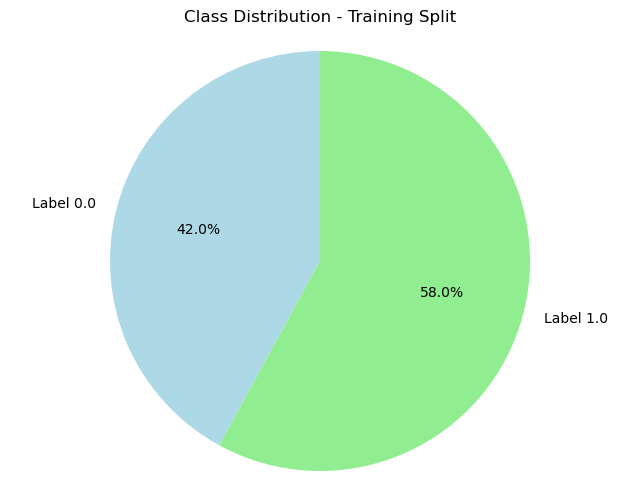


Imbalance Ratio: 1.38

First item label structure: [1.0, 1.0]

Test Split Distribution:
----------------------------
Label 0.0: 8097 samples (42.04%)
Label 1.0: 11163 samples (57.96%)


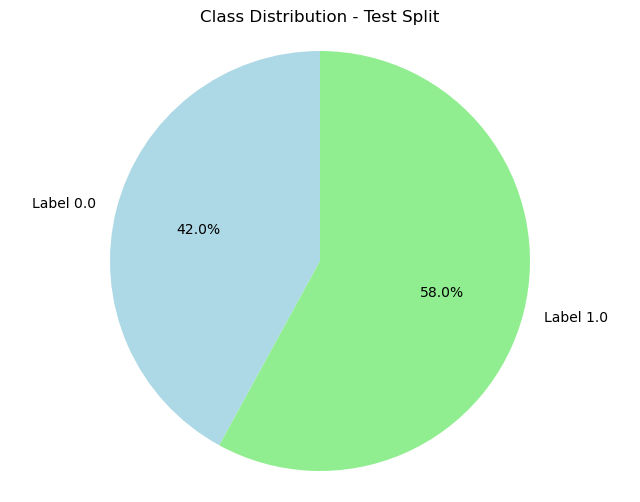


Imbalance Ratio: 1.38


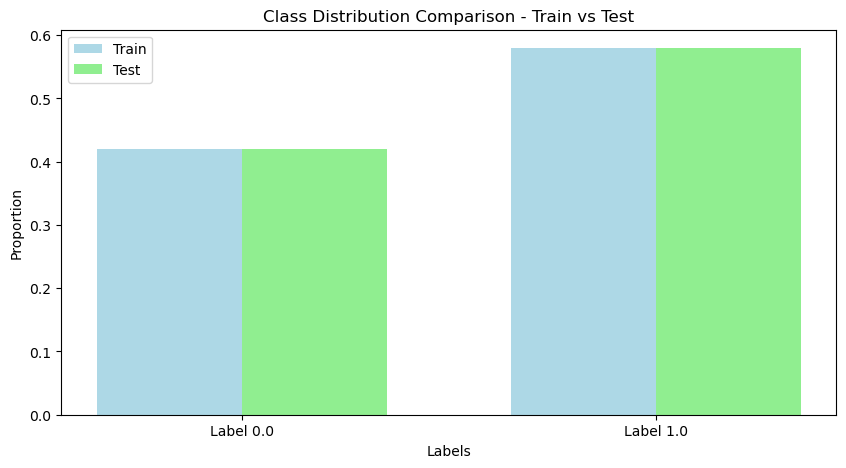


Sample Data Structure:
----------------------
id: <class 'str'> - FUHKRSUY
audio: <class 'dict'> - {'path': 'FUHKRSUY.ogg', 'array': array([ 0.22013497,  0.27519837, -0.10987435, ..., -0.05408044,
       -0.06157231, -0.05759469]), 'sampling_rate': 16000}
label: <class 'list'> - [1.0, 0.0]


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



def analyze_class_distribution(data, split_name=""):
    # First, let's examine the structure of a single item
    first_item = data[0]
    print(f"\nFirst item label structure: {first_item['label']}")
    
    # Convert dataset to a list of labels
    # If labels are lists, take the first element
    labels = []
    for item in data:
        if isinstance(item['label'], list):
            labels.append(item['label'][0])  # Take first element if it's a list
        else:
            labels.append(item['label'])
            
    # Convert to numpy array
    labels = np.array(labels)
    
    # Count unique labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_counts = pd.Series(counts, index=unique_labels)
    
    # Calculate percentages
    total_samples = len(labels)
    label_percentages = (label_counts / total_samples * 100).round(2)
    
    # Print distribution
    print(f"\n{split_name} Split Distribution:")
    print("----------------------------")
    for label, count in label_counts.items():
        percentage = label_percentages[label]
        print(f"Label {label}: {count} samples ({percentage}%)")
    
    # Create pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(label_counts, labels=[f'Label {i}' for i in label_counts.index], 
            autopct='%1.1f%%', startangle=90,
            colors=['lightblue', 'lightgreen'])
    plt.title(f'Class Distribution - {split_name} Split')
    plt.axis('equal')
    plt.show()
    
    # Calculate imbalance ratio
    if len(label_counts) > 1:
        imbalance_ratio = label_counts.max() / label_counts.min()
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio > 1.5:
            print("⚠️ Dataset is imbalanced (ratio > 1.5)")
    
    return label_counts

# Basic dataset info
print("Dataset Overview:")
print(f"Training Samples: {len(train_data)}")
print(f"Testing Samples: {len(test_data)}")

# Analyze training data
train_distribution = analyze_class_distribution(train_data, "Training")

# Analyze test data
test_distribution = analyze_class_distribution(test_data, "Test")

# Compare distributions between train and test
plt.figure(figsize=(10, 5))
train_props = train_distribution / len(train_data)
test_props = test_distribution / len(test_data)

bar_width = 0.35
index = range(len(train_props))

plt.bar(index, train_props, bar_width, label='Train', color='lightblue')
plt.bar([i + bar_width for i in index], test_props, bar_width, label='Test', color='lightgreen')

plt.xlabel('Labels')
plt.ylabel('Proportion')
plt.title('Class Distribution Comparison - Train vs Test')
plt.xticks([i + bar_width/2 for i in index], [f'Label {i}' for i in train_props.index])
plt.legend()
plt.show()

# Print sample data structure
print("\nSample Data Structure:")
print("----------------------")
sample_item = train_data[0]
for key, value in sample_item.items():
    print(f"{key}: {type(value)} - {value}")

In [9]:
import torch
import torchaudio.transforms as transforms

# Define transformation: Convert audio to Mel Spectrogram
mel_transform = transforms.MelSpectrogram(
    sample_rate=16000, n_mels=64, n_fft=1024, hop_length=512
)

# Define a fixed spectrogram length (128 frames)
FIXED_SPEC_LENGTH = 128

# Function to preprocess audio
def preprocess(example):
    waveform = example["audio"]["array"]  # Extract waveform
    waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)  # Convert to float32 & add batch dimension
    
    mel_spec = mel_transform(waveform)  # Convert to Mel spectrogram

    # Pad or truncate to fixed length
    if mel_spec.shape[2] < FIXED_SPEC_LENGTH:
        pad_amount = FIXED_SPEC_LENGTH - mel_spec.shape[2]
        mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_amount))  # Pad along time dimension
    else:
        mel_spec = mel_spec[:, :, :FIXED_SPEC_LENGTH]  # Truncate

    example["mel_spectrogram"] = mel_spec.squeeze(0)  # Remove batch dimension
    return example

# Apply preprocessing
train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

Create Dataloaders

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # First convert each mel_spectrogram to a tensor
    mel_specs = [torch.FloatTensor(item["mel_spectrogram"]) for item in batch]
    mel_specs = torch.stack(mel_specs)
    
    # Convert labels to class indices (not one-hot)
    # If your labels are already one-hot encoded, convert them to indices
    labels = [torch.argmax(torch.tensor(item["label"])) if isinstance(item["label"], (list, np.ndarray)) 
             else item["label"] for item in batch]
    labels = torch.tensor(labels, dtype=torch.long)
    
    return mel_specs, labels


# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=8, collate_fn=collate_fn)

print("✅ DataLoaders Ready!")

✅ DataLoaders Ready!


In [11]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_layers=2, num_classes=2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, seq, feature)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last timestep output
        return out

### Train & Save The Best Audio Model

In [12]:
# Training loop

# Define model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with best model saving
num_epochs = 5
best_accuracy = 0.0


for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0

    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        mel_specs, labels = batch
        # Move tensors to device
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)  # Now labels should be 1D tensor of indices

        # Reshape if needed
        if len(mel_specs.shape) == 2:
            mel_specs = mel_specs.unsqueeze(1)

        optimizer.zero_grad()
        
        try:
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        except Exception as e:
            print(f"Error during training: {str(e)}")
            print(f"mel_specs shape: {mel_specs.shape}")
            print(f"labels shape: {labels.shape}")
            print(f"labels dtype: {labels.dtype}")
            print(f"outputs shape: {outputs.shape if 'outputs' in locals() else 'N/A'}")
            print(f"outputs dtype: {outputs.dtype if 'outputs' in locals() else 'N/A'}")
            raise e

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': accuracy
        }, "best_lstm_fake_audio.pth")
        print("📁 Best model saved!")

print("✅ Training Complete!")

Epoch 1/5: 100%|██████████| 9630/9630 [07:32<00:00, 21.29it/s]


Epoch 1/5, Loss: 0.5380, Accuracy: 0.7263
📁 Best model saved!


Epoch 2/5: 100%|██████████| 9630/9630 [06:06<00:00, 26.27it/s]


Epoch 2/5, Loss: 0.4650, Accuracy: 0.7774
📁 Best model saved!


Epoch 3/5: 100%|██████████| 9630/9630 [06:06<00:00, 26.27it/s]


Epoch 3/5, Loss: 0.4177, Accuracy: 0.8086
📁 Best model saved!


Epoch 4/5: 100%|██████████| 9630/9630 [06:06<00:00, 26.25it/s]


Epoch 4/5, Loss: 0.3741, Accuracy: 0.8297
📁 Best model saved!


Epoch 5/5: 100%|██████████| 9630/9630 [06:09<00:00, 26.05it/s]

Epoch 5/5, Loss: 0.3445, Accuracy: 0.8456
📁 Best model saved!
✅ Training Complete!


### Evaluate the Audio Model

Loaded model from epoch 4 with training accuracy: 0.8456


Evaluating: 100%|██████████| 2408/2408 [01:34<00:00, 25.43it/s]



=== Model Evaluation Results ===
📊 Test Accuracy: 0.8435
📊 Precision: 0.8481
📊 Recall: 0.8435
📊 F1 Score: 0.8447

=== Confusion Matrix ===
[[10115  1848]
 [ 1166  6131]]


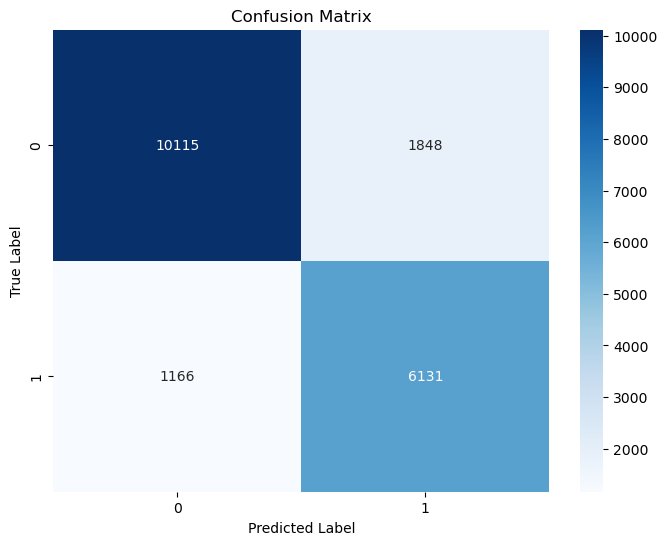

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for mel_specs, labels in tqdm(dataloader, desc="Evaluating"):
                # Move data to device
                mel_specs = mel_specs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(mel_specs)
                _, predicted = torch.max(outputs, 1)
                
                # Collect predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Calculate running accuracy
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        # Calculate metrics
        accuracy = correct / total
        
        # Convert to numpy arrays for sklearn metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        # Calculate additional metrics
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Print results
        print("\n=== Model Evaluation Results ===")
        print(f"📊 Test Accuracy: {accuracy:.4f}")
        print(f"📊 Precision: {precision:.4f}")
        print(f"📊 Recall: {recall:.4f}")
        print(f"📊 F1 Score: {f1:.4f}")
        print("\n=== Confusion Matrix ===")
        print(cm)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'true_labels': all_labels
        }
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        print(f"Last batch shapes - mel_specs: {mel_specs.shape}, labels: {labels.shape}")
        raise e

# Load and evaluate the model
try:
    # Load the best model
    checkpoint = torch.load("best_lstm_fake_audio.pth")
    if isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from epoch {checkpoint['epoch']} with training accuracy: {checkpoint['accuracy']:.4f}")
    else:
        model.load_state_dict(checkpoint)
    
    # Make sure model is on the correct device
    model = model.to(device)
    
    # Evaluate
    results = evaluate_model(model, test_loader, device)
    
    # Optional: Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
except Exception as e:
    print(f"Error loading or evaluating model: {str(e)}")


In [14]:
torch.save(model.state_dict(), "lstm_fake_news_audio_detector.pth")
print("📁 Model saved successfully!")

📁 Model saved successfully!


# 2. Model Selection & Implementation

## Text Classification (Fake News Detection with BERT)

In [21]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load trained model and tokenizer
print("\n🔄 Loading the best model...")
tokenizer = BertTokenizer.from_pretrained(best_model_path)
text_model = BertForSequenceClassification.from_pretrained(best_model_path)
text_model.to(device)
text_model.eval()
print("✅ Best model loaded successfully!")


# Predict function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    return "Fake News" if predicted_class == 0 else "Real News"

# Test prediction
text = "Can you blame her for losing her cool with Crooked Lying Hillary? Share this with all of your  undecided  friends!https://youtu.be/CCkXOix0g2Y" # Fake News
print("Prediction:", predict(text))

text = "These people will support just about anything Obama says scary stuff!" # Fake News
print("Prediction:", predict(text))

text = "Two people were shot dead on Friday as Kenyan police tried to disperse opposition supporters marching from an airport alongside the convoy of opposition leader Raila Odinga, a Reuters witness said." # Real News
print("Prediction:", predict(text))

text = "The North Korean issue should be resolved peacefully through talks, Chinese President Xi Jinping told British Prime Minister Theresa May in a telephone call, state radio said on Monday." # Real News
print("Prediction:", predict(text)) 


🔄 Loading the best model...
✅ Best model loaded successfully!
Prediction: Fake News
Prediction: Fake News
Prediction: Real News
Prediction: Real News


***

## Image Classification (CNN-based Fake Image Detection)

In [21]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict


# Initialize the model
print("\n🔄 Loading the best model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
# Modify the classifier for binary classification (Fake/Real)
model.classifier = nn.Linear(model.config.hidden_size, 2)

# Load the checkpoint
save_dir = 'model_results'
best_model_path = os.path.join(save_dir, 'best_model.pth')
checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

def predict_image(image_tensor, model):
    """
    Make prediction on a single image
    """
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor).logits
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, dim=1)
        
        return predicted.item(), confidence.item()

def load_and_preprocess_image(image_path):
    """
    Load and preprocess a specific image for prediction
    """
    try:
        # ViT specific transformations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])
        ])
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        
        print(f"✅ Successfully loaded image: {image_path}")
        return image_tensor.to(device)
    
    except Exception as e:
        print(f"❌ Error loading image: {str(e)}")
        return None

# Test specific image
print("\n🔄 Making prediction on fake_news_image.jpeg...")
image_path = 'fake_news_image.jpeg'

if os.path.exists(image_path):
    # Load and preprocess the image
    test_tensor = load_and_preprocess_image(image_path)
    
    if test_tensor is not None:
        # Make prediction
        prediction, confidence = predict_image(test_tensor, model)
        
        # Print results
        print("\nResults:")
        print(f"Image: {image_path}")
        print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")
        print(f"Confidence: {confidence:.2%}")
    else:
        print("❌ Failed to process the image.")
else:
    print(f"❌ Image not found: {image_path}")



🔄 Loading the best model...

🔄 Making prediction on fake_news_image.jpeg...
✅ Successfully loaded image: fake_news_image.jpeg

Results:
Image: fake_news_image.jpeg
Prediction: Real
Confidence: 77.84%


***

## Multimodal Fusion Model

In [10]:
from transformers import BertForSequenceClassification, BertTokenizer
from torchvision import models
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Load Text Model (BERT)
class FakeTextDetector(nn.Module):
    def __init__(self, model_path="best_bert_fake_news_detector"):
        super(FakeTextDetector, self).__init__()

        # Load BERT model & tokenizer
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(model_path)

        # Load additional checkpoint if exists
        checkpoint_path = os.path.join(model_path, "checkpoint.pth")
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            print(f"✅ Loaded trained text model from {model_path}")
        else:
            print("⚠️ Warning: Text model checkpoint not found!")

        self.model.to(device)

    def forward(self, text_inputs):
        return self.model(**text_inputs).logits


# 🔹 Load Image Model (ViT)
class FakeImageDetector(nn.Module):
    def __init__(self, save_dir='model_results', model_name='best_model.pth'):
        super(FakeImageDetector, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])
        ])

        
        # Initialize the ViT model
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        # Modify classifier for binary classification (Fake/Real)
        self.vit.classifier = nn.Linear(self.vit.config.hidden_size, 2)
        
        # Setup model path
        self.model_path = os.path.join(save_dir, model_name)
        
        # Load trained model
        try:
            if os.path.exists(self.model_path):
                checkpoint = torch.load(self.model_path, map_location=device, weights_only=True)
                state_dict = checkpoint['model_state_dict']
                
                print(f"✅ Loaded trained ViT model from {self.model_path}")    
            else:
                print(f"⚠️ Warning: ViT model checkpoint not found at {self.model_path}")
                print("Model will be initialized with random weights.")
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            print("Model will be initialized with random weights.")
            
        # Move model to device
        self.to(device)
        self.eval()  # Set to evaluation mode by default

    def forward(self, x):
        """
        Forward pass that returns logits for fusion model
        """
        outputs = self.vit(x)
        return outputs.logits

    def predict(self, image_tensor):
        """
        Standalone prediction method with confidence scores
        """
        self.eval()
        with torch.no_grad():
            outputs = self(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, dim=1)
            return predicted.item(), confidence.item()




# 🔹 Load Audio Model (LSTM)
class FakeAudioDetector(nn.Module):
    def __init__(self, audio_model_path="best_lstm_fake_audio.pth", input_size=64, hidden_size=128, num_layers=2):
        super(FakeAudioDetector, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Ensure output has 2 neurons (Fake/Real)

        # Load trained model
        if os.path.exists(audio_model_path):
            checkpoint = torch.load(audio_model_path, weights_only=True, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            
            if "model_state_dict" in checkpoint:  # Ensure compatibility
                self.load_state_dict(checkpoint["model_state_dict"])
                print(f"✅ Loaded trained audio model from {audio_model_path}")
            else:
                self.load_state_dict(checkpoint)
                print("⚠️ Warning: Model loaded without additional metadata.")

        else:
            print("⚠️ Warning: Audio model checkpoint not found!")

        self.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])


# 🔹 Multimodal Fake News Detector (Combining Text, Image & Audio)
class MultimodalFakeNewsDetector(nn.Module):
    def __init__(self):
        super(MultimodalFakeNewsDetector, self).__init__()

        # Load individual models
        self.text_model = FakeTextDetector()
        self.image_model = FakeImageDetector()
        self.audio_model = FakeAudioDetector()

        # Fusion Layer (Combining all 3 modal features)
        self.fc = nn.Linear(2 + 2 + 2, 2)  # Final classification

    def forward(self, text_inputs, image_inputs, audio_inputs):
        text_features = self.text_model(text_inputs)  # BERT output
        image_features = self.image_model(image_inputs)  # ResNet output
        audio_features = self.audio_model(audio_inputs)  # LSTM output

        fused_features = torch.cat((text_features, image_features, audio_features), dim=1)
        return self.fc(fused_features)


# 🔹 Load the multimodal model
multimodal_model = MultimodalFakeNewsDetector()
multimodal_model.eval()  # Set to evaluation mode




✅ Loaded trained text model from best_bert_fake_news_detector
✅ Loaded trained ViT model from model_results/best_model.pth
✅ Loaded trained audio model from best_lstm_fake_audio.pth


MultimodalFakeNewsDetector(
  (text_model): FakeTextDetector(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (o

# 3. Multimodal Model Training & Optimization

**custom Dataset class that handles your multimodal data**

```
mm_dataset/
├── train/
│   ├── text/
│   │   ├── sample1.txt
│   │   ├── sample2.txt
│   │   └── ...
│   ├── images/
│   │   ├── sample1.jpg
│   │   ├── sample2.jpg
│   │   └── ...
│   ├── audio/
│   │   ├── sample1.wav
│   │   ├── sample2.wav
│   │   └── ...
│   └── labels.json
└── val/
    ├── text/
    ├── images/
    ├── audio/
    └── labels.json
```

In [46]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image
import librosa
import numpy as np
from transformers import AutoTokenizer


def collate_fn(batch):
    """
    Custom collate function to handle variable length sequences
    """
    # Separate different modalities
    text_encodings = {
        'input_ids': [],
        'attention_mask': [],
        'token_type_ids': [] if 'token_type_ids' in batch[0]['text'] else None
    }
    images = []
    labels = []
    audio = []
    
    # Collect all items
    for item in batch:
        # Handle text inputs
        for key in ['input_ids', 'attention_mask']:
            text_encodings[key].append(item['text'][key])
        if text_encodings['token_type_ids'] is not None:
            text_encodings['token_type_ids'].append(item['text']['token_type_ids'])
            
        # Handle images and labels
        images.append(item['image'])
        labels.append(item['labels'])
        audio.append(item['audio'])
    
    # Pad and stack text inputs
    max_length = max(len(ids) for ids in text_encodings['input_ids'])
    
    for key in ['input_ids', 'attention_mask']:
        if text_encodings[key]:
            # Pad sequences to max length
            padded = [
                torch.nn.functional.pad(
                    seq, 
                    (0, max_length - len(seq)), 
                    value=0 if key == 'input_ids' else 0
                ) 
                for seq in text_encodings[key]
            ]
            text_encodings[key] = torch.stack(padded)
    
    if text_encodings['token_type_ids'] is not None:
        padded = [
            torch.nn.functional.pad(
                seq, 
                (0, max_length - len(seq)), 
                value=0
            ) 
            for seq in text_encodings['token_type_ids']
        ]
        text_encodings['token_type_ids'] = torch.stack(padded)
    
    # Stack other modalities
    images = torch.stack(images)
    labels = torch.stack(labels)
    audio = torch.stack(audio) 
    
    return {
        'text': text_encodings,
        'image': images,
        'audio': audio,
        'labels': labels
    }




class MultimodalDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        
        self.split = split
        self.transform = transform
        
        # Define paths
        self.split_dir = os.path.join(root_dir, split)
        self.text_dir = os.path.join(self.split_dir, 'text')
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.audio_dir = os.path.join(self.split_dir, 'audio')  
        
        # Load labels
        with open(os.path.join(self.split_dir, 'labels.json'), 'r') as f:
            self.labels = json.load(f)
            
        # Get list of sample IDs
        self.sample_ids = sorted(list(self.labels.keys()))
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.sample_ids)
    
    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        
        # audio loading
        audio_path = os.path.join(self.audio_dir, f"{sample_id}.wav")  
        try:
            audio, sr = librosa.load(audio_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
            # Add fixed-size padding or cropping if needed
            target_length = 64  # Choose appropriate size
            if mel_spec.shape[1] > target_length:
                mel_spec = mel_spec[:, :target_length]
            else:
                # Pad with zeros
                pad_width = ((0, 0), (0, target_length - mel_spec.shape[1]))
                mel_spec = np.pad(mel_spec, pad_width, mode='constant')
            mel_spec = torch.from_numpy(mel_spec).float()
        except:
            mel_spec = torch.zeros((128, target_length))  # Consistent dimensions
        
        # Load text
        text_path = os.path.join(self.text_dir, f"{sample_id}.txt")
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Tokenize text
        text_encodings = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by tokenizer
        text_encodings = {key: val.squeeze(0) for key, val in text_encodings.items()}

        # Load image
        image_path = os.path.join(self.image_dir, f"{sample_id}.jpg")
        image = Image.open(image_path).convert('RGB')
        
        # Apply transforms if any
        if self.transform:
            image = self.transform(image)
        
        # Get label
        label = self.labels[sample_id]
        
        # Return dictionary
        return {
            'text': text_encodings,
            'image': image,
            'audio': mel_spec,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create datasets
train_dataset = MultimodalDataset(
    root_dir='mm_dataset',
    split='train',
    transform=transform
)

val_dataset = MultimodalDataset(
    root_dir='mm_dataset',
    split='val',
    transform=transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn  
)



# Test the dataloader
print("Testing dataloader...")
for batch_idx, batch in enumerate(train_loader):
    print("\nBatch structure:")
    for key, value in batch.items():
        if key == 'text':
            print("\nText inputs:")
            for k, v in value.items():
                print(f"{k}: shape {v.shape}, dtype {v.dtype}")
        else:
            print(f"\n{key}: shape {value.shape}, dtype {value.dtype}")
    
    # Only print first batch
    break

print("✅ Multimodal model DataLoaders Ready!")

Testing dataloader...

Batch structure:

Text inputs:
input_ids: shape torch.Size([5, 392]), dtype torch.int64
attention_mask: shape torch.Size([5, 392]), dtype torch.int64
token_type_ids: shape torch.Size([5, 392]), dtype torch.int64

image: shape torch.Size([5, 3, 224, 224]), dtype torch.float32

audio: shape torch.Size([5, 128, 64]), dtype torch.float32

labels: shape torch.Size([5]), dtype torch.int64
✅ Multimodal model DataLoaders Ready!


**Training**

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

# 🔹 Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Hyperparameters
num_epochs = 5
learning_rate = 2e-5
batch_size = 8
best_val_accuracy = 0.0

# 🔹 Load multimodal model
multimodal_model = MultimodalFakeNewsDetector().to(device)

# 🔹 Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(multimodal_model.parameters(), lr=learning_rate)


# 🔹 Training Loop
print("\n🚀 Training Multimodal Model...")
for epoch in range(num_epochs):
    multimodal_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Unpack the batch properly
        text_inputs = batch['text']
        image_inputs = batch['image']
        labels = batch['labels']
        audio_inputs = batch['audio']

        # Move data to device
        text_inputs = {k: v.to(device) for k, v in text_inputs.items() if v is not None}
        image_inputs = image_inputs.to(device)
        labels = labels.to(device)
        audio_inputs = audio_inputs.to(device)

        try:
            # Forward pass
            outputs = multimodal_model(
                text_inputs=text_inputs,
                image_inputs=image_inputs,
                audio_inputs=audio_inputs 
            )
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track performance
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        except Exception as e:
            print(f"Error in batch: {str(e)}")
            continue

    # Calculate epoch metrics
    train_accuracy = correct / total if total > 0 else 0
    avg_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
    
    print(f"📊 Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Validation step
    multimodal_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            # Unpack validation batch
            text_inputs = batch['text']
            image_inputs = batch['image']
            labels = batch['labels']
            audio_inputs = batch['audio']

            # Move to device
            text_inputs = {k: v.to(device) for k, v in text_inputs.items() if v is not None}
            image_inputs = image_inputs.to(device)
            labels = labels.to(device)
            audio_inputs = audio_inputs.to(device) 

            try:
                # Forward pass
                outputs = multimodal_model(
                    text_inputs=text_inputs,
                    image_inputs=image_inputs,
                    audio_inputs=audio_inputs 
                )
                loss = criterion(outputs, labels)

                # Track validation performance
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

            except Exception as e:
                print(f"Error in validation batch: {str(e)}")
                continue

    # Calculate validation metrics
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    
    print(f"✅ Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': multimodal_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_accuracy': best_val_accuracy
        }, "best_multimodal_model.pth")
        print("📁 Best Multimodal Model Saved!")

print("🏁 Training Complete!")




✅ Loaded trained text model from best_bert_fake_news_detector
✅ Loaded trained ViT model from model_results/best_model.pth
✅ Loaded trained audio model from best_lstm_fake_audio.pth

🚀 Training Multimodal Model...


Epoch 1/5: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

📊 Epoch 1/5 - Loss: 0.6634, Accuracy: 0.6000


✅ Validation - Loss: 0.4589, Accuracy: 1.0000
📁 Best Multimodal Model Saved!


Epoch 2/5: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

📊 Epoch 2/5 - Loss: 0.4620, Accuracy: 1.0000


✅ Validation - Loss: 0.3302, Accuracy: 1.0000


Epoch 3/5: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

📊 Epoch 3/5 - Loss: 0.3352, Accuracy: 1.0000


✅ Validation - Loss: 0.2444, Accuracy: 1.0000


Epoch 4/5: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

📊 Epoch 4/5 - Loss: 0.2469, Accuracy: 1.0000


✅ Validation - Loss: 0.1931, Accuracy: 1.0000


Epoch 5/5: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

📊 Epoch 5/5 - Loss: 0.1970, Accuracy: 1.0000


✅ Validation - Loss: 0.1585, Accuracy: 1.0000
🏁 Training Complete!


# 4. Evaluation & Performance Testing


🔍 Evaluating Model Performance...


Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



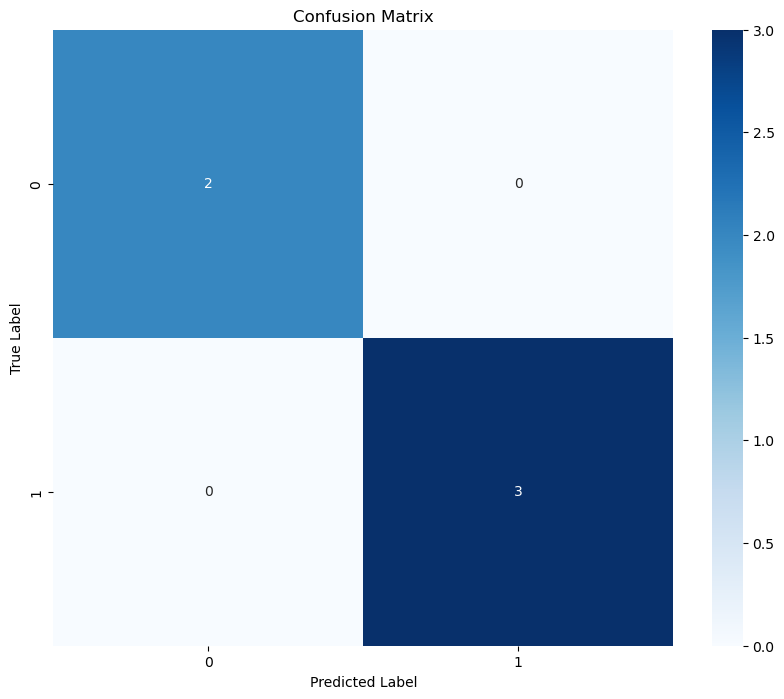

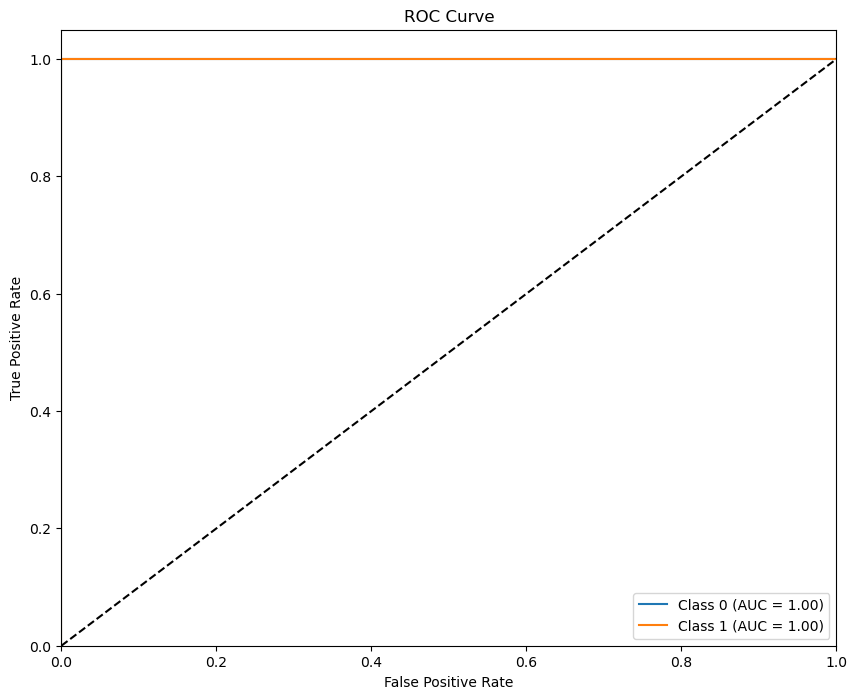

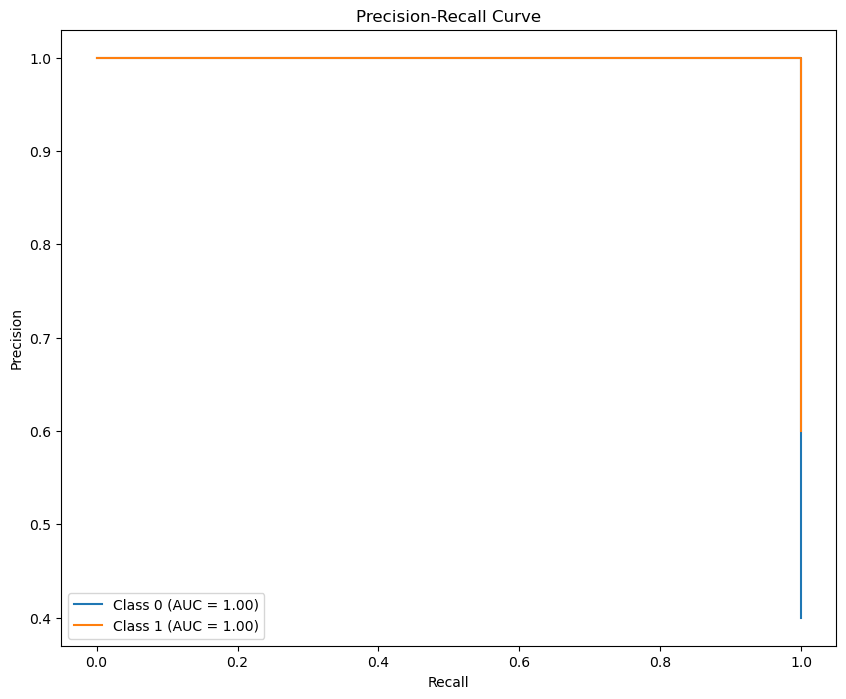


📈 Overall Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

✅ Results saved to model_evaluation_results


In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import os
import json
import torch.multiprocessing as mp

def evaluate_model_performance(model, test_loader, device):
    """
    Evaluate model performance with multiple metrics
    """
    # Set multiprocessing start method
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            try:
                # Get batch data
                text_inputs = {k: v.to(device) for k, v in batch['text'].items() if v is not None}
                image_inputs = batch['image'].to(device)
                audio_inputs = batch['audio'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(
                    text_inputs=text_inputs,
                    image_inputs=image_inputs,
                    audio_inputs=audio_inputs
                )
                
                # Get predictions and probabilities
                probabilities = torch.softmax(outputs, dim=1)
                _, predictions = torch.max(outputs, 1)
                
                # Move tensors to CPU and convert to numpy
                predictions = predictions.cpu().numpy()
                probabilities = probabilities.cpu().numpy()
                labels = labels.cpu().numpy()
                
                # Store results
                all_predictions.extend(predictions)
                all_probabilities.extend(probabilities)
                all_labels.extend(labels)
                
            except Exception as e:
                print(f"Error processing batch: {str(e)}")
                continue
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)
    
    return plot_metrics(all_labels, all_predictions, all_probabilities)

# Modified DataLoader setup
def create_data_loader(dataset, batch_size, shuffle=False):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True if torch.cuda.is_available() else False,
        collate_fn=collate_fn
    )

def main():
    # Ensure this code runs in the main process
    if __name__ == '__main__':
        try:
            # Create data loaders with modified settings
            val_loader = create_data_loader(
                dataset=val_dataset,
                batch_size=batch_size,
                shuffle=False
            )
            
            # Ensure model is in evaluation mode
            multimodal_model.eval()
            
            # Clear GPU cache if using CUDA
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Run evaluation
            metrics = evaluate_and_save_results(
                model=multimodal_model,
                test_loader=val_loader,
                device=device
            )
            
        except Exception as e:
            print(f"Error during evaluation: {str(e)}")

# Run the evaluation
if __name__ == '__main__':
    # Set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the validation data loader
    val_loader = create_data_loader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    # Ensure model is on the correct device
    multimodal_model = multimodal_model.to(device)
    
    # Run evaluation
    print("\n🔍 Evaluating Model Performance...")
    metrics = evaluate_and_save_results(
        model=multimodal_model,
        test_loader=val_loader,
        device=device
    )





